In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import utils as ut

import os

In [2]:
data = pd.read_parquet('../data/input/data_features_3000_vins.parquet')
data

,vehicule_id,start_charge,battery_age,total_km_interp,SOH_CC,BSOC_start,BSOC_end,delta_BSOC,dt_last_cd_c,Duration_stb_a,...,I_cum,I_max,HVBTemperatureMax_start,HVBTemperatureMin_start,HVBTemperatureAverage_start,ExternalTempValue_start,HVBTemperatureMax_end,HVBTemperatureMin_end,HVBTemperatureAverage_end,ExternalTempValue_end
0,set:jeu8|vin:vin0001,2020-11-20 16:10:16+00:00,0.059340,168.96,100.106511,95.526515,99.559033,4.032518,0.166667,54.0,...,22763.750,22.875,10.000000,9.109670,9.002225,4.998888,15.693467,13.760784,12.993029,3.502324
1,set:jeu8|vin:vin0001,2020-11-23 08:13:15+00:00,0.066646,319.93,68.505355,42.625032,55.719691,13.094659,1.766667,176.0,...,50585.250,27.250,7.307766,6.000000,6.000000,6.000000,8.867925,8.000000,8.000000,7.000000
2,set:jeu8|vin:vin0001,2020-11-23 14:20:18+00:00,0.067344,334.35,88.721194,48.900013,91.068188,42.168175,1.500000,178.0,...,210968.380,27.125,10.000000,9.000000,9.000000,8.500000,13.000000,12.000000,12.000000,3.500000
3,set:jeu8|vin:vin0001,2020-11-24 15:02:40+00:00,0.070162,396.96,102.035835,64.314808,99.559033,35.244225,0.700000,54.0,...,202789.690,25.625,7.000000,6.000000,6.000000,4.250000,13.100503,11.102564,13.997887,4.499925
4,set:jeu8|vin:vin0001,2020-11-27 11:24:30+00:00,0.077961,522.63,92.778900,45.638931,99.472222,53.833291,0.650000,271.0,...,281647.120,26.750,7.963253,7.000000,7.000000,6.486842,13.000000,11.000000,11.999222,4.252139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600709,set:jeu8|vin:vin3059,2023-08-28 15:35:20+00:00,2.772483,39174.15,78.097075,26.683359,81.141679,54.458321,1.333333,80.0,...,239830.380,58.000,22.147608,22.227045,22.000000,16.000000,26.971510,29.000000,28.993334,15.253333
600710,set:jeu8|vin:vin3059,2023-08-31 15:26:52+00:00,2.780681,39391.66,75.915664,23.150013,65.240755,42.090742,0.650000,85.0,...,180186.880,58.250,23.347475,23.000000,23.000000,26.000000,31.000000,30.000000,30.000000,27.250000
600711,set:jeu8|vin:vin3059,2023-09-04 15:27:04+00:00,2.791633,39501.29,73.776968,37.263889,61.773134,24.509245,1.116667,55.0,...,101966.125,57.500,27.000000,26.000000,26.000000,29.000000,31.000000,30.000000,29.995468,31.747168
600712,set:jeu8|vin:vin3059,2023-09-08 17:44:52+00:00,2.802846,39653.59,79.247858,25.812468,88.507564,62.695096,832.566667,5.0,...,280173.000,58.375,28.000000,27.540997,27.000000,24.750000,29.931746,25.000000,27.011494,23.001915


# Discovery

In [3]:
age_battery = data.groupby('vehicule_id')['start_charge'].count()
age_battery.mean()

200.03796203796205

In [6]:
X_cols_cleaned = [
    'battery_age',
    'total_km_interp',
    'BSOC_start', 'delta_BSOC',
    'dt_last_cd_c',
    'Duration_stb_a',
    'temperature',
    'freq_I_charge', 'I_cum', 'I_max',
    'delta_t',
    'HVBTemperatureAverage_start',
    'HVBTemperatureAverage_end',
    'ExternalTempValue_start'
]
len(X_cols_cleaned)

14

In [4]:
veh_id = data['vehicule_id'].value_counts().idxmax()
df_v = data[data['vehicule_id'] == veh_id]['battery_age'].max()
df_vX_cols_cleaned

2.841229022485867

In [5]:
veh_id = data['vehicule_id'].value_counts().idxmax()
df_v = data[data['vehicule_id'] == veh_id].sort_values('start_charge').copy()
df_v.shape

(2201, 23)

In [4]:
window_size = 5
sigma = 0.25
df_v['rolling_mean'] = df_v['SOH_CC'].rolling(window=window_size, center=False).mean()
rolling_std = df_v['SOH_CC'].rolling(window=window_size).std()
df_v['upper_bound'] = df_v['rolling_mean'] + sigma * rolling_std
df_v['lower_bound'] = df_v['rolling_mean'] - 2.5*sigma * rolling_std

#threshold mask
df_v = df_v[ df_v['SOH_CC'] >= df_v['lower_bound'] ]


#censure
#censoring_mask = ( (df_v['SOH_CC'] >= df_v['lower_bound']) & (df_v['SOH_CC'] <= df_v['upper_bound']) )
censoring_mask = ( (df_v['SOH_CC'] <= df_v['upper_bound']) )
df_v['delta'] = censoring_mask.astype(int)

print(f'Censoring level : {1-df_v.delta.mean()}')

Censoring level : 0.605296343001261


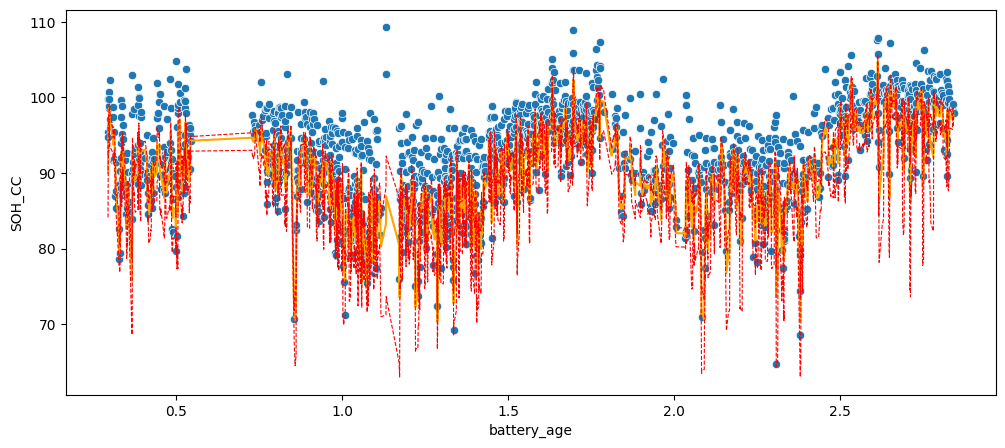

In [5]:
plt.figure(figsize=(12, 5))
sns.scatterplot(data=df_v,
                    x='battery_age',
                    y='SOH_CC')
sns.lineplot(data=df_v,
             x='battery_age',
             y='rolling_mean',
             color='orange')
sns.lineplot(data=df_v,
             x='battery_age',
             y='upper_bound',
             color='red',
             linewidth=0.8,
             linestyle='--')
sns.lineplot(data=df_v,
             x='battery_age',
             y='lower_bound',
             color='red',
             linewidth=0.8,
             linestyle='--')

plt.show()

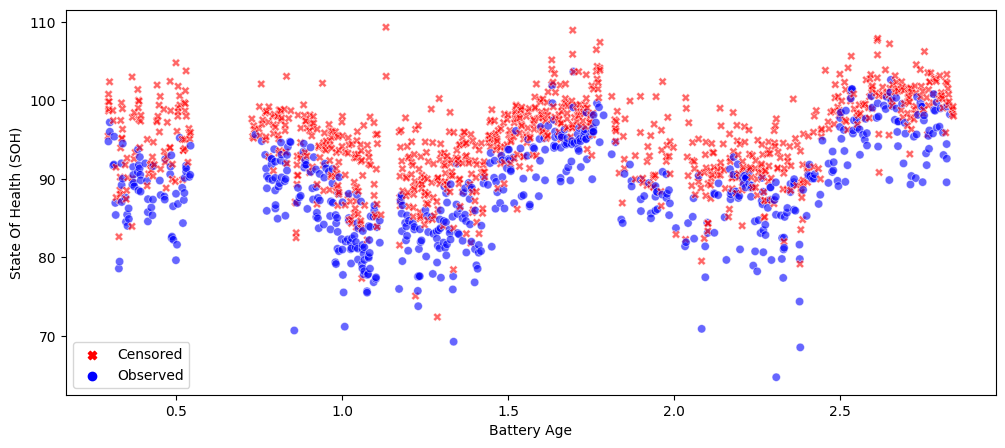

In [6]:
df_plot = df_v.copy()
df_plot['delta_label'] = df_plot['delta'].map({1: 'Observed', 0: 'Censored'})

plt.figure(figsize=(12, 5))
sns.scatterplot(data=df_plot, x='battery_age', y='SOH_CC', 
                hue='delta_label', palette={'Observed': 'blue', 'Censored': 'red'}, 
                style='delta_label', markers={'Observed': 'o', 'Censored': 'X'}, 
                alpha=0.6)

plt.xlabel("Battery Age")
plt.ylabel("State Of Health (SOH)")
plt.legend(loc='lower left')
plt.savefig('soh_vs_battery_age')
plt.show()

In [14]:
from sklearn.preprocessing import StandardScaler

X_cols_cleaned = [
    'battery_age',
    'total_km_interp',
    'BSOC_start', 'delta_BSOC',
    'dt_last_cd_c',
    'Duration_stb_a',
    'temperature',
    'freq_I_charge', 'I_cum', 'I_max',
    'delta_t',
    'HVBTemperatureAverage_start',
    'HVBTemperatureAverage_end',
    'ExternalTempValue_start'
]

scaler = StandardScaler()
X = scaler.fit_transform(df_v[X_cols_cleaned])
#y = df_v['SOH_CC']
delta = df_v['delta'].to_numpy()
df_v['clipped'] = df_v['SOH_CC'].clip(upper=df_v['upper_bound'])
#T_tilde = df_v['SOH_CC'].clip(lower=df_v['lower_bound'], upper=df_v['upper_bound'])
T_tilde = df_v['SOH_CC'].clip(upper=df_v['upper_bound']).to_numpy()

In [15]:
X.shape, delta.shape, T_tilde.shape

((1586, 14), (1586,), (1586,))

In [67]:
#Training
kernel = ut.RBF().kernel
n=len(T_tilde)
lambda_pen = n**(-1/2)
tau_2 = 0.05

QR_model_2 = ut.TCSVM_biased(kernel=kernel, lambda_=lambda_pen, tau=tau_2)
QR_model_2.fit(X=X, delta=delta, T_c=T_tilde, func_cond_surv=ut.cond_survival)

y_pred_2 = QR_model_2.predict(X)

KeyboardInterrupt: 

In [93]:
#Training
kernel = ut.RBF().kernel
n=len(T_tilde)
lambda_pen = n**(-1/2)
tau = 0.9

QR_model = ut.TCSVM_biased(kernel=kernel, lambda_=lambda_pen, tau=tau)
QR_model.fit(X=X, delta=delta, T_c=T_tilde, func_cond_surv=ut.cond_survival)

y_pred_1 = QR_model.predict(X)

/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:141: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv


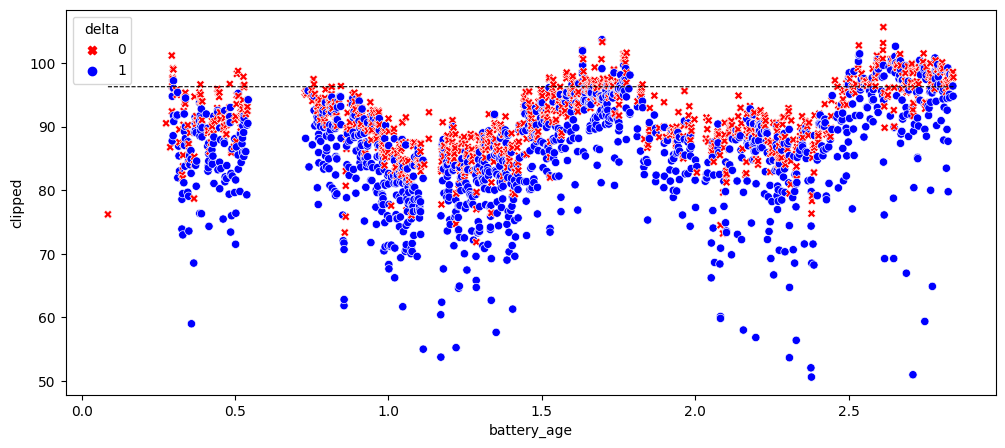

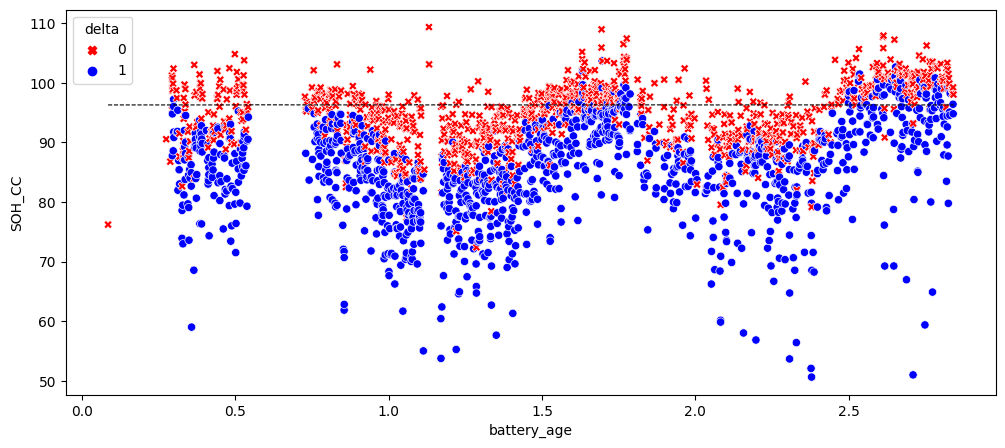

In [97]:
plt.figure(figsize=(12, 5))
#sns.scatterplot(data=df_v,
#                    x='battery_age',
#                    y='SOH_CC')
sns.scatterplot(data=df_v, x='battery_age', y='clipped', 
                hue='delta', palette={0: 'red', 1: 'blue'}, 
                style='delta', markers={0: 'X', 1: 'o'}, 
                alpha=1)
#plt.plot(df_v.battery_age, y_pred_1, color='black', linewidth=0.8, linestyle='--')
plt.plot(df_v.battery_age, y_pred_2, color='black', linewidth=0.8, linestyle='--')
#sns.lineplot(data=df_v,
#             x='battery_age',
#             y='lower_bound',
#             color='red',
#             linewidth=0.8,
#             linestyle='--')

plt.show()

plt.figure(figsize=(12, 5))
#sns.scatterplot(data=df_v,
#                    x='battery_age',
#                    y='SOH_CC')
sns.scatterplot(data=df_v, x='battery_age', y='SOH_CC', 
                hue='delta', palette={0: 'red', 1: 'blue'}, 
                style='delta', markers={0: 'X', 1: 'o'}, 
                alpha=1)
#plt.plot(df_v.battery_age, y_pred_1, color='black', linewidth=0.8, linestyle='--')
plt.plot(df_v.battery_age, y_pred_2, color='black', linewidth=0.8, linestyle='--')
#sns.lineplot(data=df_v,
#             x='battery_age',
#             y='lower_bound',
#             color='red',
#             linewidth=0.8,
#             linestyle='--')

plt.show()

In [92]:
y_pred_1, y_pred_2

(array([87.36251397, 87.36251397, 87.36251397, ..., 87.36251397,
        87.63926919, 87.36251397]),
 array([96.25637925, 96.25637925, 96.25637925, ..., 96.25637925,
        96.28006252, 96.25637925]))

In [1]:
#CENTREES-REDUIRE
#Prendre les données rouges, je les réhausse brutalement + aléatoirement
#jouer les expés 3 fois. 
#1 fois où on suppose que toutes nos données sont exactes avec une méthode "classique"
#Une autre fois où on a censuré par un bruit aléatoire vers le bas avec notre méthode
#Une autre fois où on a censuré par un bruit aléatoire vers le bas la meme méthode classique.


#Ne pas hésiter à enlever les données en dessous de 2*std glissant.
#obj:illustrer la méthode

#données censurées partout : supply, fiab, veh connectees. -> déclinaison des méthodes de ML aux données censurées
#Mise en valeur du traitement des données censurées. pb de regression, de regression et de scoring 
#Données cenusées \in les données manquantes, incomplètes ou incertaines. Pb de qualité de données. Y en a qui sont censurées (cas particulier).
#qu'on retrouve à différents endroits.

#Ask Johanna et Nicolas pour loi de roulage.

In [ ]:
#Certaines variobles incertaines en raison de la manière dont elles ont ete acquises et on sait que certaines valeurs de SOH
#sont plus elevees qu'elle devait être

In [17]:
-On suppose que nos données ne sont pas censurées et appliquons une méthode classique ne prenant pas en compte la censure
-De même, où on discard les données censurées
-On se compare une méthode IPCW classique

SyntaxError: invalid syntax (3305420847.py, line 1)

# Training

In [22]:
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import sys

X_cols_cleaned = [
    'battery_age',
    'total_km_interp',
    'BSOC_start', 'delta_BSOC',
    'dt_last_cd_c',
    'Duration_stb_a',
    'temperature',
    'freq_I_charge', 'I_cum', 'I_max',
    'delta_t',
    'HVBTemperatureAverage_start',
    'HVBTemperatureAverage_end',
    'ExternalTempValue_start'
]

trick = 1/sys.float_info.epsilon

In [4]:
def handling_censorship(df, window_size=5, sigma=0.1, verbose=False):
    df['rolling_mean'] = df['SOH_CC'].rolling(window=window_size, center=False).mean()
    rolling_std = df['SOH_CC'].rolling(window=window_size).std()
    df['upper_bound'] = df['rolling_mean'] + sigma * rolling_std
    df['lower_bound'] = df['rolling_mean'] - 2.5*sigma * rolling_std

    #threshold mask
    df = df[ df['SOH_CC'] >= df['lower_bound'] ]

    #censorship
    #censoring_mask = ( (df_v['SOH_CC'] >= df_v['lower_bound']) & (df_v['SOH_CC'] <= df_v['upper_bound']) )
    censoring_mask = ( (df['SOH_CC'] <= df['upper_bound']) )
    df['delta'] = censoring_mask.astype(int)
    if verbose:
        print(f'Censoring level : {1-df.delta.mean()}')
        
    scaler = StandardScaler()
    X = scaler.fit_transform(df[X_cols_cleaned])
    delta = df['delta'].to_numpy()
    df['clipped'] = df['SOH_CC'].clip(upper=df['upper_bound'])
    #T_tilde = df_v['SOH_CC'].clip(lower=df_v['lower_bound'], upper=df_v['upper_bound'])
    T_tilde = df['SOH_CC'].clip(upper=df['upper_bound']).to_numpy()    
    
    return X, delta, T_tilde

In [5]:
def pinball_loss(u, tau):
    """
    Fonction de perte quantile : rho_tau(u) = (tau - 1{u < 0}) * u
    """
    return (tau - (u < 0)) * u

def IPCW_pinball_loss(X, delta, T, model, tau, trick):
    arr_cond_surv = ut.cond_survival(T, 1 - delta, X)
    weights = delta / arr_cond_surv 
    weights = np.where((np.isnan(weights)) | (arr_cond_surv < 0.1), trick, weights)
    
    return ( weights*pinball_loss( T - model.predict(X), tau) ).mean()

## Try

In [6]:
veh_id = data['vehicule_id'].value_counts().idxmax()
#df_v = data[data['vehicule_id'] == veh_id].sort_values('start_charge').copy()
#df_v.shape
df_v = data[data['vehicule_id'] == veh_id].sort_values('battery_age').copy()
df_v['SOH_CC'] = 100-df_v['SOH_CC']
df_v

,vehicule_id,start_charge,battery_age,total_km_interp,SOH_CC,BSOC_start,BSOC_end,delta_BSOC,dt_last_cd_c,Duration_stb_a,...,I_cum,I_max,HVBTemperatureMax_start,HVBTemperatureMin_start,HVBTemperatureAverage_start,ExternalTempValue_start,HVBTemperatureMax_end,HVBTemperatureMin_end,HVBTemperatureAverage_end,ExternalTempValue_end
49304,set:jeu8|vin:vin0247,2020-12-10 07:35:28+00:00,0.085739,80.71,23.808350,75.308340,82.808321,7.499981,0.933333,118.0,...,32223.500,24.500,3.000000,3.000000,3.000000,2.250000,3.000000,3.000000,3.000000,2.250000
49305,set:jeu8|vin:vin0247,2021-02-17 13:05:09+00:00,0.275278,649.18,9.484630,82.287487,88.128782,5.841295,6.733333,180.0,...,29815.125,23.625,8.000000,-11.877666,7.000000,-2.535714,8.000000,-2.665562,7.000000,-2.750000
49306,set:jeu8|vin:vin0247,2021-02-22 09:59:03+00:00,0.288613,729.65,13.254753,65.472215,79.617436,14.145221,0.866667,39.0,...,69192.750,24.500,9.063753,9.098040,9.772727,12.386364,9.369287,10.000000,11.000000,5.519231
49307,set:jeu8|vin:vin0247,2021-02-24 08:23:21+00:00,0.293907,920.13,-1.163538,92.881950,99.211816,6.329866,0.966667,135.0,...,36109.688,23.750,3.040541,8.409449,8.000000,4.250000,15.000000,13.000000,13.995242,5.499009
49308,set:jeu8|vin:vin0247,2021-02-24 12:17:02+00:00,0.294351,966.54,4.548263,92.100705,98.777788,6.677083,1.233333,109.0,...,35939.812,23.625,-13.500000,-9.651055,12.000000,8.500413,-13.500000,2.459084,12.000000,8.749724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51500,set:jeu8|vin:vin0247,2023-09-11 19:13:04+00:00,2.838606,88722.55,1.780758,72.391654,99.038194,26.646540,0.750000,107.0,...,147585.120,15.875,21.000000,20.000000,20.000000,16.000000,20.340103,19.409882,20.000000,15.750000
51501,set:jeu8|vin:vin0247,2023-09-12 03:54:31+00:00,2.839597,88738.78,3.630274,94.527772,99.385411,4.857639,0.950000,63.0,...,26398.000,15.000,19.000000,18.000000,18.000000,16.000000,19.000000,18.000000,18.000000,16.249800
51502,set:jeu8|vin:vin0247,2023-09-12 06:28:25+00:00,2.839890,88776.48,0.804390,88.034079,99.038194,11.004115,0.983333,383.0,...,61553.500,15.000,19.440481,19.078302,19.000000,15.750000,20.441093,19.656921,19.000000,16.999750
51503,set:jeu8|vin:vin0247,2023-09-12 09:40:13+00:00,2.840254,88839.06,5.227954,83.867418,98.777788,14.910370,1.900000,38.0,...,79684.500,15.250,21.000000,20.122076,20.000000,19.593750,21.350077,20.464842,20.000000,20.500000


In [12]:
def handling_censorship(df, window_size=5, sigma=0.1, verbose=False):
    df['rolling_mean'] = df['SOH_CC'].rolling(window=window_size, center=False).mean()
    rolling_std = df['SOH_CC'].rolling(window=window_size).std()
    df['upper_bound'] = df['rolling_mean'] + sigma * rolling_std
    df['lower_bound'] = df['rolling_mean'] - 2.5*sigma * rolling_std

    #threshold mask
    df = df[ df['SOH_CC'] >= df['lower_bound'] ]

    #censorship
    #censoring_mask = ( (df_v['SOH_CC'] >= df_v['lower_bound']) & (df_v['SOH_CC'] <= df_v['upper_bound']) )
    censoring_mask = ( (df['SOH_CC'] <= df['upper_bound']) )
    df['delta'] = censoring_mask.astype(int)
    if verbose:
        print(f'Censoring level : {1-df.delta.mean()}')
        
    scaler = StandardScaler()
    X = scaler.fit_transform(df[X_cols_cleaned])
    delta = df['delta'].to_numpy()
    df['clipped'] = df['SOH_CC'].clip(upper=df['upper_bound'])
    #T_tilde = df_v['SOH_CC'].clip(lower=df_v['lower_bound'], upper=df_v['upper_bound'])
    T_tilde = df['SOH_CC'].clip(upper=df['upper_bound']).to_numpy()    
    
    return X, delta, T_tilde

In [13]:
X, delta, T_tilde = handling_censorship(df_v, verbose=True)
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)
delta_train, delta_test = train_test_split(delta, test_size=0.2, shuffle=False)
T_tilde_train, T_tilde_test = train_test_split(T_tilde, test_size=0.2, shuffle=False)

Censoring level : 0.7696038803556993


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
#Training
kernel = ut.RBF().kernel
n_train=len(T_tilde_train)
lambda_pen = n_train**(-1/2)
tau = 0.95

TCSVM_model = ut.TCSVM_biased(kernel=kernel, lambda_=lambda_pen, tau=tau)
TCSVM_model.fit(X=X_train, delta=delta_train, T_c=T_tilde_train, func_cond_surv=ut.cond_survival)

/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:141: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv


TCSVM_biased(kernel=<bound method RBF.kernel of <utils.RBF object at 0x7f891f904f90>>,
             lambda_=0.02795084971874737, tau=0.95)

In [14]:
CSVM_model = ut.CSVM_biased(kernel=kernel, lambda_=lambda_pen, tau=tau, arr_cond_surv=ut.cond_survival(T_tilde_train, 1 - delta_train, X_train))
CSVM_model.fit(X=X_train, delta=delta_train, T_c=T_tilde_train, trick=0)

<class 'numpy.ndarray'>


/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:194: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv


CSVM_biased(arr_cond_surv=array([0.05708333, 0.019     , 0.08233333, ..., 0.03166667, 0.2875    ,
       0.072     ]),
            kernel=<bound method RBF.kernel of <utils.RBF object at 0x7f891f904f90>>,
            lambda_=0.02795084971874737, tau=0.95)

In [16]:
def pinball_loss(u, tau):
    """
    Fonction de perte quantile : rho_tau(u) = (tau - 1{u < 0}) * u
    """
    return (tau - (u < 0)) * u

def IPCW_pinball_loss(X, delta, T, model, tau, trick):
    arr_cond_surv = ut.cond_survival(T, 1 - delta, X)
    weights = delta / arr_cond_surv 
    weights = np.where((np.isnan(weights)) | (arr_cond_surv < 0.1), trick, weights)
    
    return ( weights*pinball_loss( T - model.predict(X), tau) ).mean()

In [17]:
IPCW_pinball_loss(X_test, delta_test, T_tilde_test, TCSVM_model, tau, 0), IPCW_pinball_loss(X_test, delta_test, T_tilde_test, CSVM_model, tau, 0)

(5.471569741236842, 5.390977279501792)

## Loop

In [23]:
li_veh_id = data['vehicule_id'].value_counts().head(20).index.tolist()
R_hat = { 'TCSVM' : [], 'CSVM' : [] }

for veh_id in tqdm(li_veh_id):
    df_v = data[data['vehicule_id'] == veh_id].sort_values('battery_age').copy()
    #Transformation
    df_v['SOH_CC'] = 100-df_v['SOH_CC']
    X, delta, T_tilde = handling_censorship(df_v, sigma=0.05,verbose=True)
    X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)
    delta_train, delta_test = train_test_split(delta, test_size=0.2, shuffle=False)
    T_tilde_train, T_tilde_test = train_test_split(T_tilde, test_size=0.2, shuffle=False)
    
    #Training
    kernel = ut.RBF().kernel
    n_train=len(T_tilde_train)
    lambda_pen = n_train**(-1/2)
    tau = 0.95

    TCSVM_model = ut.TCSVM_biased(kernel=kernel, lambda_=lambda_pen, tau=tau)
    TCSVM_model.fit(X=X_train, delta=delta_train, T_c=T_tilde_train, func_cond_surv=ut.cond_survival)
    
    CSVM_model = ut.CSVM_biased(kernel=kernel, lambda_=lambda_pen, tau=tau, arr_cond_surv=ut.cond_survival(T_tilde_train, 1 - delta_train, X_train))
    CSVM_model.fit(X=X_train, delta=delta_train, T_c=T_tilde_train, trick=trick)
    
    R_hat['TCSVM'].append( IPCW_pinball_loss(X_test, delta_test, T_tilde_test, TCSVM_model, tau, trick) )
    R_hat['CSVM'].append( IPCW_pinball_loss(X_test, delta_test, T_tilde_test, CSVM_model, tau, trick) )
    print(R_hat)

  0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Censoring level : 0.8743362831858407


/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:141: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:194: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
  5%|▌         | 1/20 [00:56<17:46, 56.13s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/cond

{'TCSVM': [2.1732491336181076e+16], 'CSVM': [2.9612541555951812e+16]}
Censoring level : 0.8973346495557749


/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:141: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:194: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
 10%|█         | 2/20 [01:42<15:07, 50.44s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/cond

{'TCSVM': [2.1732491336181076e+16, 3.5443380094765776e+16], 'CSVM': [2.9612541555951812e+16, 2.9121355046289452e+16]}
Censoring level : 0.8830242510699001


/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:141: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:194: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
 15%|█▌        | 3/20 [02:04<10:33, 37.24s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/cond

{'TCSVM': [2.1732491336181076e+16, 3.5443380094765776e+16, 4.505946929560004e+16], 'CSVM': [2.9612541555951812e+16, 2.9121355046289452e+16, 3.816740908613312e+16]}
Censoring level : 0.8767550702028081


/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:141: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:194: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
 20%|██        | 4/20 [02:25<08:16, 31.00s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/cond

{'TCSVM': [2.1732491336181076e+16, 3.5443380094765776e+16, 4.505946929560004e+16, 3.497993405500907e+16], 'CSVM': [2.9612541555951812e+16, 2.9121355046289452e+16, 3.816740908613312e+16, 4.018595284420729e+16]}
Censoring level : 0.8631178707224334


/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:141: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:194: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
 25%|██▌       | 5/20 [02:45<06:47, 27.14s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

{'TCSVM': [2.1732491336181076e+16, 3.5443380094765776e+16, 4.505946929560004e+16, 3.497993405500907e+16, 2792494232102849.0], 'CSVM': [2.9612541555951812e+16, 2.9121355046289452e+16, 3.816740908613312e+16, 4.018595284420729e+16, 2.643625112912333e+16]}
Censoring level : 0.864


/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:141: RuntimeWarning: divide by zero encountered in true_divide
  w = delta / arr_cond_surv
/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:141: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:194: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
 30%|███       | 6/20 [02:56<05:00, 21.48s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

{'TCSVM': [2.1732491336181076e+16, 3.5443380094765776e+16, 4.505946929560004e+16, 3.497993405500907e+16, 2792494232102849.0, 1.460683017672936e+16], 'CSVM': [2.9612541555951812e+16, 2.9121355046289452e+16, 3.816740908613312e+16, 4.018595284420729e+16, 2.643625112912333e+16, 2.1838105266835484e+16]}
Censoring level : 0.874751491053678


/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:141: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:194: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
 35%|███▌      | 7/20 [03:08<04:01, 18.59s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/cond

{'TCSVM': [2.1732491336181076e+16, 3.5443380094765776e+16, 4.505946929560004e+16, 3.497993405500907e+16, 2792494232102849.0, 1.460683017672936e+16, 5.1155771763335976e+16], 'CSVM': [2.9612541555951812e+16, 2.9121355046289452e+16, 3.816740908613312e+16, 4.018595284420729e+16, 2.643625112912333e+16, 2.1838105266835484e+16, 6.255105365911219e+16]}
Censoring level : 0.8891352549889135


/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:141: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:194: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
 40%|████      | 8/20 [03:22<03:22, 16.90s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/cond

{'TCSVM': [2.1732491336181076e+16, 3.5443380094765776e+16, 4.505946929560004e+16, 3.497993405500907e+16, 2792494232102849.0, 1.460683017672936e+16, 5.1155771763335976e+16, 4438216737154407.5], 'CSVM': [2.9612541555951812e+16, 2.9121355046289452e+16, 3.816740908613312e+16, 4.018595284420729e+16, 2.643625112912333e+16, 2.1838105266835484e+16, 6.255105365911219e+16, 3.935577394020137e+16]}
Censoring level : 0.8849372384937239


/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:141: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:194: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
 45%|████▌     | 9/20 [03:40<03:10, 17.36s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/cond

{'TCSVM': [2.1732491336181076e+16, 3.5443380094765776e+16, 4.505946929560004e+16, 3.497993405500907e+16, 2792494232102849.0, 1.460683017672936e+16, 5.1155771763335976e+16, 4438216737154407.5, 2697515385855514.0], 'CSVM': [2.9612541555951812e+16, 2.9121355046289452e+16, 3.816740908613312e+16, 4.018595284420729e+16, 2.643625112912333e+16, 2.1838105266835484e+16, 6.255105365911219e+16, 3.935577394020137e+16, 4.487314666394683e+16]}
Censoring level : 0.8825995807127882


/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:141: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:194: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
 50%|█████     | 10/20 [03:52<02:37, 15.79s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

{'TCSVM': [2.1732491336181076e+16, 3.5443380094765776e+16, 4.505946929560004e+16, 3.497993405500907e+16, 2792494232102849.0, 1.460683017672936e+16, 5.1155771763335976e+16, 4438216737154407.5, 2697515385855514.0, 1.7944970651506502e+16], 'CSVM': [2.9612541555951812e+16, 2.9121355046289452e+16, 3.816740908613312e+16, 4.018595284420729e+16, 2.643625112912333e+16, 2.1838105266835484e+16, 6.255105365911219e+16, 3.935577394020137e+16, 4.487314666394683e+16, 6.665904150647271e+16]}
Censoring level : 0.8855140186915887


/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:141: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:194: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
 55%|█████▌    | 11/20 [04:02<02:03, 13.76s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/con

{'TCSVM': [2.1732491336181076e+16, 3.5443380094765776e+16, 4.505946929560004e+16, 3.497993405500907e+16, 2792494232102849.0, 1.460683017672936e+16, 5.1155771763335976e+16, 4438216737154407.5, 2697515385855514.0, 1.7944970651506502e+16, 2.445373104386466e+16], 'CSVM': [2.9612541555951812e+16, 2.9121355046289452e+16, 3.816740908613312e+16, 4.018595284420729e+16, 2.643625112912333e+16, 2.1838105266835484e+16, 6.255105365911219e+16, 3.935577394020137e+16, 4.487314666394683e+16, 6.665904150647271e+16, 3.0321666627325976e+16]}
Censoring level : 0.9017094017094017


/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:141: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:194: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
 60%|██████    | 12/20 [04:11<01:40, 12.59s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithC

{'TCSVM': [2.1732491336181076e+16, 3.5443380094765776e+16, 4.505946929560004e+16, 3.497993405500907e+16, 2792494232102849.0, 1.460683017672936e+16, 5.1155771763335976e+16, 4438216737154407.5, 2697515385855514.0, 1.7944970651506502e+16, 2.445373104386466e+16, 2.7053838894277724e+16], 'CSVM': [2.9612541555951812e+16, 2.9121355046289452e+16, 3.816740908613312e+16, 4.018595284420729e+16, 2.643625112912333e+16, 2.1838105266835484e+16, 6.255105365911219e+16, 3.935577394020137e+16, 4.487314666394683e+16, 6.665904150647271e+16, 3.0321666627325976e+16, 7.64592461395888e+16]}
Censoring level : 0.8835616438356164


/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:141: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:194: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
 65%|██████▌   | 13/20 [04:25<01:29, 12.77s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/con

{'TCSVM': [2.1732491336181076e+16, 3.5443380094765776e+16, 4.505946929560004e+16, 3.497993405500907e+16, 2792494232102849.0, 1.460683017672936e+16, 5.1155771763335976e+16, 4438216737154407.5, 2697515385855514.0, 1.7944970651506502e+16, 2.445373104386466e+16, 2.7053838894277724e+16, 8640881355058092.0], 'CSVM': [2.9612541555951812e+16, 2.9121355046289452e+16, 3.816740908613312e+16, 4.018595284420729e+16, 2.643625112912333e+16, 2.1838105266835484e+16, 6.255105365911219e+16, 3.935577394020137e+16, 4.487314666394683e+16, 6.665904150647271e+16, 3.0321666627325976e+16, 7.64592461395888e+16, 5.356757273226168e+16]}
Censoring level : 0.863080684596577


/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:141: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:194: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
 70%|███████   | 14/20 [04:38<01:17, 12.85s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/con

{'TCSVM': [2.1732491336181076e+16, 3.5443380094765776e+16, 4.505946929560004e+16, 3.497993405500907e+16, 2792494232102849.0, 1.460683017672936e+16, 5.1155771763335976e+16, 4438216737154407.5, 2697515385855514.0, 1.7944970651506502e+16, 2.445373104386466e+16, 2.7053838894277724e+16, 8640881355058092.0, 2.8753643404551644e+16], 'CSVM': [2.9612541555951812e+16, 2.9121355046289452e+16, 3.816740908613312e+16, 4.018595284420729e+16, 2.643625112912333e+16, 2.1838105266835484e+16, 6.255105365911219e+16, 3.935577394020137e+16, 4.487314666394683e+16, 6.665904150647271e+16, 3.0321666627325976e+16, 7.64592461395888e+16, 5.356757273226168e+16, 3.907001756325738e+16]}
Censoring level : 0.8847926267281105


/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:141: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:194: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
 75%|███████▌  | 15/20 [04:48<01:01, 12.21s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/con

{'TCSVM': [2.1732491336181076e+16, 3.5443380094765776e+16, 4.505946929560004e+16, 3.497993405500907e+16, 2792494232102849.0, 1.460683017672936e+16, 5.1155771763335976e+16, 4438216737154407.5, 2697515385855514.0, 1.7944970651506502e+16, 2.445373104386466e+16, 2.7053838894277724e+16, 8640881355058092.0, 2.8753643404551644e+16, 1.8248923102069896e+16], 'CSVM': [2.9612541555951812e+16, 2.9121355046289452e+16, 3.816740908613312e+16, 4.018595284420729e+16, 2.643625112912333e+16, 2.1838105266835484e+16, 6.255105365911219e+16, 3.935577394020137e+16, 4.487314666394683e+16, 6.665904150647271e+16, 3.0321666627325976e+16, 7.64592461395888e+16, 5.356757273226168e+16, 3.907001756325738e+16, 3.919900638177698e+16]}
Censoring level : 0.8575581395348837


/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:141: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:194: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
 80%|████████  | 16/20 [04:54<00:41, 10.30s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/con

{'TCSVM': [2.1732491336181076e+16, 3.5443380094765776e+16, 4.505946929560004e+16, 3.497993405500907e+16, 2792494232102849.0, 1.460683017672936e+16, 5.1155771763335976e+16, 4438216737154407.5, 2697515385855514.0, 1.7944970651506502e+16, 2.445373104386466e+16, 2.7053838894277724e+16, 8640881355058092.0, 2.8753643404551644e+16, 1.8248923102069896e+16, 4.390935274985275e+16], 'CSVM': [2.9612541555951812e+16, 2.9121355046289452e+16, 3.816740908613312e+16, 4.018595284420729e+16, 2.643625112912333e+16, 2.1838105266835484e+16, 6.255105365911219e+16, 3.935577394020137e+16, 4.487314666394683e+16, 6.665904150647271e+16, 3.0321666627325976e+16, 7.64592461395888e+16, 5.356757273226168e+16, 3.907001756325738e+16, 3.919900638177698e+16, 3.3256302759503796e+16]}
Censoring level : 0.8693467336683417


/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:141: RuntimeWarning: divide by zero encountered in true_divide
  w = delta / arr_cond_surv
/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:141: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:194: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
 85%|████████▌ | 17/20 [05:02<00:28,  9.51s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

{'TCSVM': [2.1732491336181076e+16, 3.5443380094765776e+16, 4.505946929560004e+16, 3.497993405500907e+16, 2792494232102849.0, 1.460683017672936e+16, 5.1155771763335976e+16, 4438216737154407.5, 2697515385855514.0, 1.7944970651506502e+16, 2.445373104386466e+16, 2.7053838894277724e+16, 8640881355058092.0, 2.8753643404551644e+16, 1.8248923102069896e+16, 4.390935274985275e+16, 1.1959233310486134e+16], 'CSVM': [2.9612541555951812e+16, 2.9121355046289452e+16, 3.816740908613312e+16, 4.018595284420729e+16, 2.643625112912333e+16, 2.1838105266835484e+16, 6.255105365911219e+16, 3.935577394020137e+16, 4.487314666394683e+16, 6.665904150647271e+16, 3.0321666627325976e+16, 7.64592461395888e+16, 5.356757273226168e+16, 3.907001756325738e+16, 3.919900638177698e+16, 3.3256302759503796e+16, 7.03716357791011e+16]}
Censoring level : 0.8555555555555556


/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:141: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:194: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
 90%|█████████ | 18/20 [05:09<00:17,  8.72s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/con

{'TCSVM': [2.1732491336181076e+16, 3.5443380094765776e+16, 4.505946929560004e+16, 3.497993405500907e+16, 2792494232102849.0, 1.460683017672936e+16, 5.1155771763335976e+16, 4438216737154407.5, 2697515385855514.0, 1.7944970651506502e+16, 2.445373104386466e+16, 2.7053838894277724e+16, 8640881355058092.0, 2.8753643404551644e+16, 1.8248923102069896e+16, 4.390935274985275e+16, 1.1959233310486134e+16, 4716006719427220.0], 'CSVM': [2.9612541555951812e+16, 2.9121355046289452e+16, 3.816740908613312e+16, 4.018595284420729e+16, 2.643625112912333e+16, 2.1838105266835484e+16, 6.255105365911219e+16, 3.935577394020137e+16, 4.487314666394683e+16, 6.665904150647271e+16, 3.0321666627325976e+16, 7.64592461395888e+16, 5.356757273226168e+16, 3.907001756325738e+16, 3.919900638177698e+16, 3.3256302759503796e+16, 7.03716357791011e+16, 4.877710889844309e+16]}
Censoring level : 0.8950276243093923


/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:141: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:194: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
 95%|█████████▌| 19/20 [05:16<00:08,  8.22s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/con

{'TCSVM': [2.1732491336181076e+16, 3.5443380094765776e+16, 4.505946929560004e+16, 3.497993405500907e+16, 2792494232102849.0, 1.460683017672936e+16, 5.1155771763335976e+16, 4438216737154407.5, 2697515385855514.0, 1.7944970651506502e+16, 2.445373104386466e+16, 2.7053838894277724e+16, 8640881355058092.0, 2.8753643404551644e+16, 1.8248923102069896e+16, 4.390935274985275e+16, 1.1959233310486134e+16, 4716006719427220.0, 2824036969317491.5], 'CSVM': [2.9612541555951812e+16, 2.9121355046289452e+16, 3.816740908613312e+16, 4.018595284420729e+16, 2.643625112912333e+16, 2.1838105266835484e+16, 6.255105365911219e+16, 3.935577394020137e+16, 4.487314666394683e+16, 6.665904150647271e+16, 3.0321666627325976e+16, 7.64592461395888e+16, 5.356757273226168e+16, 3.907001756325738e+16, 3.919900638177698e+16, 3.3256302759503796e+16, 7.03716357791011e+16, 4.877710889844309e+16, 2.2978402975140336e+16]}
Censoring level : 0.8837209302325582


/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:141: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/home/jupyter/doc/QuantReg/soh/qr_flo/utils.py:194: RuntimeWarning: invalid value encountered in true_divide
  w = delta / arr_cond_surv
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":
100%|██████████| 20/20 [05:29<00:00, 16.49s/it]

{'TCSVM': [2.1732491336181076e+16, 3.5443380094765776e+16, 4.505946929560004e+16, 3.497993405500907e+16, 2792494232102849.0, 1.460683017672936e+16, 5.1155771763335976e+16, 4438216737154407.5, 2697515385855514.0, 1.7944970651506502e+16, 2.445373104386466e+16, 2.7053838894277724e+16, 8640881355058092.0, 2.8753643404551644e+16, 1.8248923102069896e+16, 4.390935274985275e+16, 1.1959233310486134e+16, 4716006719427220.0, 2824036969317491.5, 3.22510120766789e+16], 'CSVM': [2.9612541555951812e+16, 2.9121355046289452e+16, 3.816740908613312e+16, 4.018595284420729e+16, 2.643625112912333e+16, 2.1838105266835484e+16, 6.255105365911219e+16, 3.935577394020137e+16, 4.487314666394683e+16, 6.665904150647271e+16, 3.0321666627325976e+16, 7.64592461395888e+16, 5.356757273226168e+16, 3.907001756325738e+16, 3.919900638177698e+16, 3.3256302759503796e+16, 7.03716357791011e+16, 4.877710889844309e+16, 2.2978402975140336e+16, 5.628346497633493e+16]}


In [25]:
for key in R_hat:
    print(key)
    print(np.array(R_hat[key]).mean())
    print(np.array(R_hat[key]).std())

TCSVM
2.1683086667691256e+16
1.4953563467903158e+16
CSVM
4.345425277655038e+16
1.5742643266481512e+16
